# Wie ist das Kaufverhalten?

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import locale

Daten einlesen / aufbereiten

In [4]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "email", "transaction_id"]], on="transaction_id"))


df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifisiche Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)


In [5]:
df_reg_main = df_reg_main.assign(count=[1 for i in range(len(df_reg_main))])

In [6]:
df_reg_main.describe()

,date,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,transaction_id,...,month,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,count
count,335253,300164.000000,335253.000000,335253.000000,335253.000000,335253.000000,75253.000000,110000.00000,150000.000000,335253.000000,...,335253.000000,335253.0,335253.000000,335253.000000,335253.00000,335253.000000,335253.000000,335253.000000,335253.000000,335253.0
mean,2022-05-13 00:24:06.816583424,0.988871,2.405234,0.224466,0.328110,0.447423,286.214998,211.65353,855.001512,170761.352584,...,6.574745,26.73928,516.238937,1162.729318,748.38011,1739.700176,232.141173,576.970857,7.587594,1.0
min,2021-11-01 00:00:00,0.900000,1.000000,0.000000,0.000000,0.000000,150.000000,136.02000,486.090000,0.000000,...,1.000000,1.0,136.020000,136.020000,499.00000,499.000000,-186.370000,-2050.070000,1.600000,1.0
25%,2022-02-13 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,215.000000,171.57000,805.340000,85937.000000,...,4.000000,14.0,206.730000,447.340000,550.00000,999.000000,133.130000,215.940000,6.700000,1.0
50%,2022-05-18 00:00:00,1.000000,2.000000,0.000000,0.000000,0.000000,276.590000,196.21000,859.115000,171144.000000,...,7.000000,27.0,349.530000,862.610000,680.00000,1497.000000,230.190000,392.620000,7.700000,1.0
75%,2022-08-13 00:00:00,1.000000,3.000000,0.000000,1.000000,1.000000,344.040000,259.94000,909.410000,255788.000000,...,9.000000,39.0,847.510000,1705.780000,999.00000,2116.000000,350.620000,768.750000,8.700000,1.0
max,2022-10-31 00:00:00,1.000000,17.000000,1.000000,1.000000,1.000000,685.370000,326.26000,985.000000,339999.000000,...,12.000000,52.0,985.000000,9557.520000,999.00000,12987.000000,512.910000,7110.600000,10.000000,1.0
std,NaN,0.031449,1.579624,0.417231,0.469526,0.497229,86.871362,51.42493,73.858664,98109.396928,...,3.329539,14.505512,314.110280,939.646248,228.49302,1125.267154,120.618094,548.731709,1.580079,0.0


In [7]:
df_reg_main.head()

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost,price,revenue,profit_per_unit,profit,customer_rating,email,region,marketplace,count
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,850.10,529,2645,358.98,1794.90,7.1,friedhilde.kuhl@yahoo.de,A,online,1
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,1190.14,529,3703,358.98,2512.86,5.9,heide-marie.fischer@gmx.de,A,online,1
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,1470.21,529,3703,318.97,2232.79,7.5,ester.pruschke@gmail.com,A,online,1
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,1700.80,529,5290,358.92,3589.20,6.6,klaus.blümel@aol.de,A,online,1
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,680.36,529,2116,358.91,1435.64,7.3,waldemar.fritsch@web.de,A,online,1


In [8]:
df_reg_main.columns

Index(['date', 'product', 'discount', 'amount', 'basic', 'mini', 'pro',
       'cost_basic', 'cost_mini', 'cost_pro', 'transaction_id', 'year',
       'month', 'week', 'year_month', 'cost_per_unit', 'cost', 'price',
       'revenue', 'profit_per_unit', 'profit', 'customer_rating', 'email',
       'region', 'marketplace', 'count'],
      dtype='object')

Daten einlesen schon einer Dokumentiert?

# **Transaktionen**

## Wie entwickelt sich die Transaktionsanzahl pro Zeiteinheit (monatlich)?

Im Folgenden wird betrachtet, wie sich die Anzahl monatlicher Transaktionen über den Erfassungszeitraum der Daten entwickelt.

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


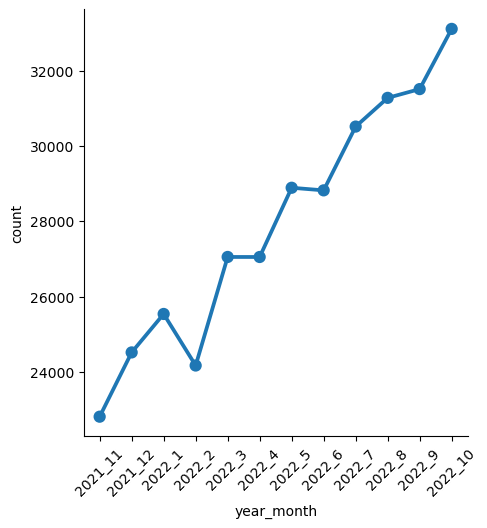

In [9]:
cat = sns.catplot(data=df_reg_main, x="year_month", y="count", estimator="sum", kind="point", errorbar=None)
cat.set_xticklabels(rotation=45)

Die Darstellung zeigt, dass die Anzahl monatlicher Transaktionen kontinuierlich über das Jahr hinweg steigt.

Als nächstes wird die durchschnittliche Menge an verkauften Produkten pro Transaktion pro Monat betrachtet. 

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


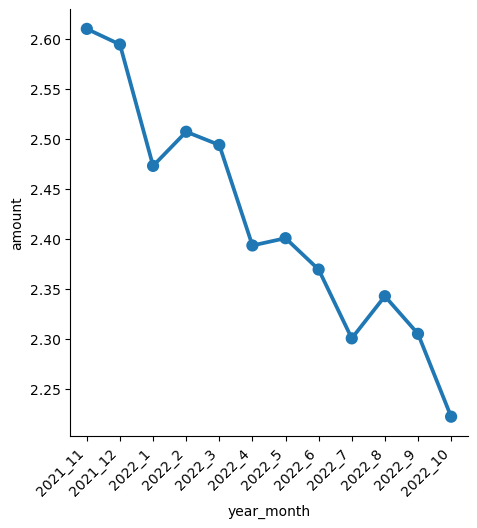

In [10]:
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", kind="point", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

Diese Darstellung zeigt, dass die durchschnittliche Anzahl an Tablets pro Transaktion kontinuierlich sinkt. 

Zusammenfassend lässt sich zu den Transaktionen also sagen, dass die Anzahl an Transaktionen zwar steigt, jedoch die Anzahl an Produkten pro Transkation sinkt. Kunden also tendenziell weniger Produkte pro Bestellung kaufen.

# **Menge**

## Wie entwickelt sich die verkaufte Menge pro Produkt?
Nachfolgend wird betrachtet wie sich die Verkaufsmengen pro Tablet-Variante entwickeln.

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


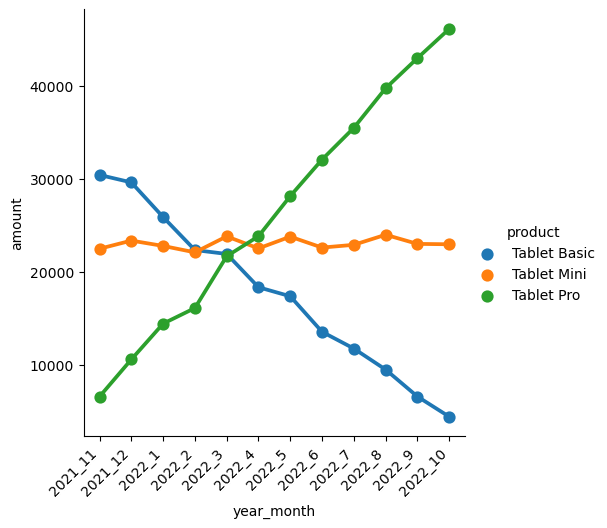

In [11]:
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", estimator="sum", kind="point", hue="product", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

In dieser Darstellung zeigt sich, dass die Verkaufsmenge Tablet Mini gleichbleibend ist. Für das Tablet Basic sinkt die verkaufte Menge kontinuierlich und die Anzahl der verkauften Tablet Pros steigt.

Resultierende Frage / These: Wird mit dem Pro Modell weniger Marge gemacht, als mit dem Basic Modell? 
Sodass weniger Marge dann auch noch höhere Verwaltungskosten durch gestiegene Anzahl an Transaktionen gegenüber stehen?

# **Discounts**

## Wie entwickeln sich die Discounts im Vergleich auf den verschiedenen Marktplätzen?
Nachfolgend wird betrachtet wie sich die durchschnittlichen Rabatte, die gewährt werden pro Marktplatz entwickeln.

Der Discount-Wert zeigt an, wie viel vom normalen Preis gezahlt werden musste, 1 - dieser Wert ergibt dementsprechend den Rabatt der gewährt wurde.


C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


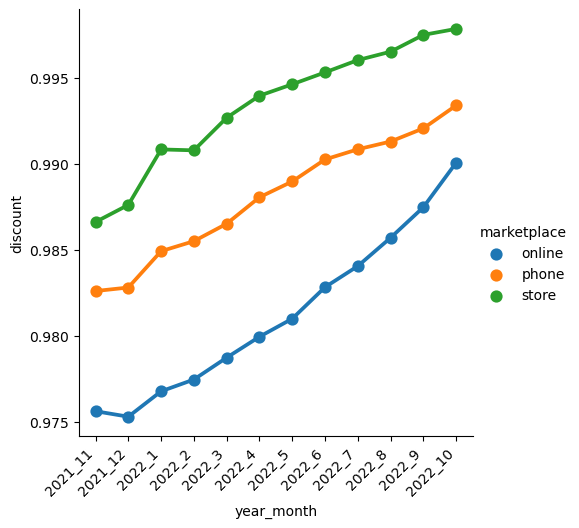

In [12]:
chart = sns.catplot(data=df_reg_main, x="year_month", y="discount", kind="point", hue="marketplace", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

Zu sehen ist, dass der durchschnittliche Anteil, der vom Normal-Preis gezahlt wurde, auf allen Marktplätzen ansteigt. D.h. auf allen Marktplätzen wurden im Verlauf des betrachteten Zeitraums zunehmen weniger Rabatte gewährt. Dabei werden im Store generell geringere Rabatte gewährt als auf den anderen Marktplätzen.

## Wie entwickelt sich die Anzahl an verkauften Tablets bei einem Discount im Vergleich zu keinem Discount?
Hier soll betrachtet werden wie sich die Anzahl der verkauften Tablets mit und ohne einen Rabatt insgesamt entwickeln.

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


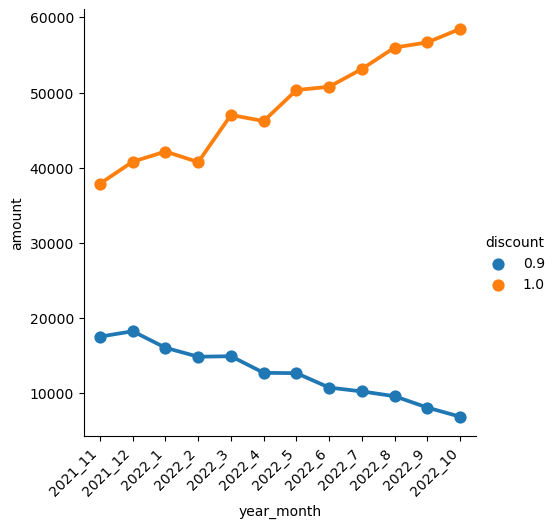

In [14]:
# Entwicklung der Summe der Menge an verkauften Produkten
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", kind="point", hue="discount", estimator="sum", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

Die Anzahl der verkauften Tablets die nicht rabatiert sind steigt, die der rabatierten sinkt. Das deckt sich auch mit der Beobachtung, dass der durchschnittlich gegebene Rabatt pro Monat für alle Verkaufskanäle sinkt.

Eine weitere Frage ist, wie sich die Rabatte im Verhältnis zu der durschnittlich verkauften Menge pro Transaktion entwickeln.

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


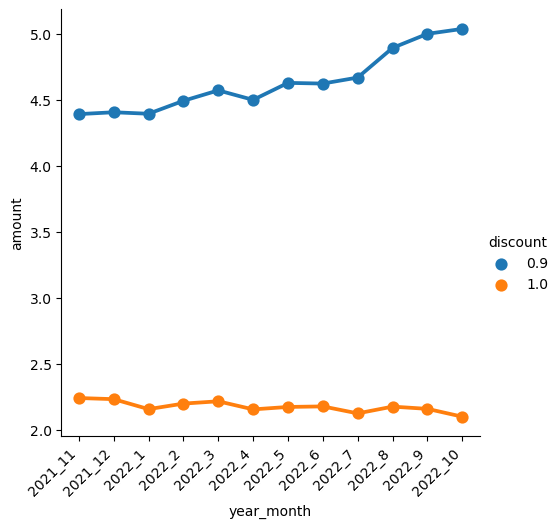

In [15]:
# Entwicklung der Durschschnittsmenge pro Transkation
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", kind="point", hue="discount", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

Hier ist zu sehen, dass die durchschnittliche Menge von Produkten in einer Transaktion, die einen Discount bekommen etwas ansteigt und die durchschnittliche Menge von Produkten pro Transaktion die keinen Discount bekommen leicht absinkt.

Nachfolgend wird gezeigt, wie sich die Anzahl an Produkten, auf die ein Rabatt gewährt wurde insgesamt entwickelt.

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


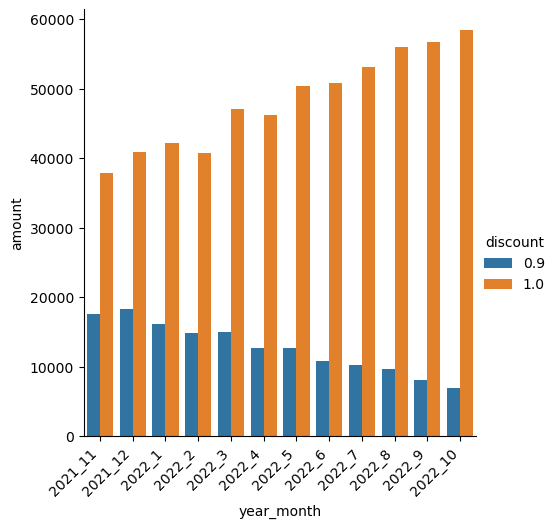

In [16]:
# Entwicklung der Summe der Menge an verkauften Produkten pro discount
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", hue="discount", kind="bar", estimator="sum", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

Es ist zu beobachten, dass auch die absolute Zahl von verkauften Produkten, auf die ein Rabatt gegeben wird sinkt.

# **Gewinn**

## Wie entwickeln sich Umsatz und Kosten pro Produkt?
-> Gewinn / Profit pro Einheit sinkt für Tablet Basic und Pro (doch wie oben zu sehen steigt der Verkauf für Tablet Pro => Gewinn insgesamt sinkt)

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


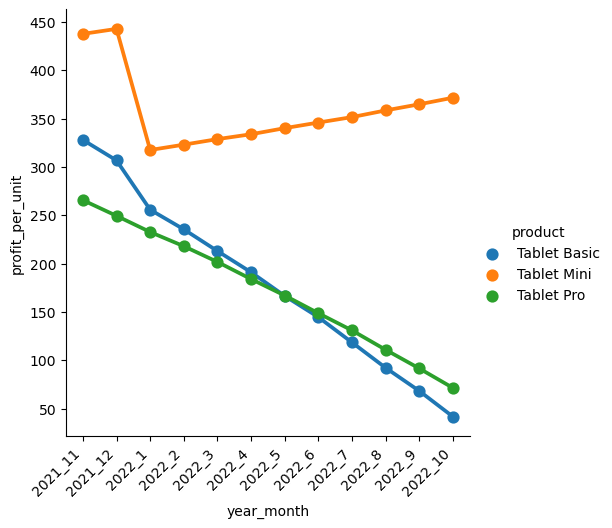

In [17]:
chart = sns.catplot(data=df_reg_main, x="year_month", y="profit_per_unit", kind="point", errorbar=None, hue="product")
chart.set_xticklabels(rotation=45, horizontalalignment='right')

# Weitergehende Analyse der Regionen und Marktplätze
In Bezug auf die These: Tablet Basic ist nicht profitabel

In [18]:
df_basic = df_reg_main[df_reg_main["product"] == "Tablet Basic"]

df_basic

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost,price,revenue,profit_per_unit,profit,customer_rating,email,region,marketplace,count
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,850.10,529,2645,358.98,1794.90,7.1,friedhilde.kuhl@yahoo.de,A,online,1
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,1190.14,529,3703,358.98,2512.86,5.9,heide-marie.fischer@gmx.de,A,online,1
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,1470.21,529,3703,318.97,2232.79,7.5,ester.pruschke@gmail.com,A,online,1
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,1700.80,529,5290,358.92,3589.20,6.6,klaus.blümel@aol.de,A,online,1
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,680.36,529,2116,358.91,1435.64,7.3,waldemar.fritsch@web.de,A,online,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292429,2022-10-27,Tablet Basic,0.9,3,1,0,0,535.74,NaN,NaN,...,1607.22,499,1497,-36.74,-110.22,4.4,ralf.killer@googlemail.com,D,store,1
292430,2022-10-27,Tablet Basic,0.9,7,1,0,0,655.75,NaN,NaN,...,4590.25,499,3493,-156.75,-1097.25,2.9,ditmar.fechner@googlemail.com,D,store,1
292431,2022-10-29,Tablet Basic,1.0,1,1,0,0,537.91,NaN,NaN,...,537.91,499,499,-38.91,-38.91,4.2,marie-louise.thanel@googlemail.com,D,store,1
292432,2022-10-29,Tablet Basic,1.0,1,1,0,0,537.93,NaN,NaN,...,537.93,499,499,-38.93,-38.93,4.9,gabor.seidel@hotmail.de,D,store,1


In [19]:
stats_per_month = df_basic.groupby(pd.Grouper(key="date",freq="1M")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "mean"})
stats_per_week = df_basic.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "mean"})
stats_per_month

,transaction_id,price,cost_per_unit,profit_per_unit,revenue,amount
date,,,,,,
2021-11-30,10759,529.0,200.830756,328.169244,1496.874802,2.829631
2021-12-31,10417,529.0,222.049048,306.950952,1505.240376,2.845445
2022-01-31,9325,499.0,243.053416,255.946584,1386.444075,2.778445
2022-02-28,7920,499.0,263.356908,235.643092,1408.729924,2.823106
2022-03-31,7667,499.0,285.830811,213.169189,1427.945741,2.861615
2022-04-30,6642,499.0,307.756781,191.243219,1379.049082,2.763625
2022-05-31,6114,499.0,332.284848,166.715152,1418.811907,2.843310
2022-06-30,4856,499.0,354.196365,144.803635,1393.212932,2.792010
2022-07-31,4227,499.0,380.369250,118.630750,1387.921221,2.781405


Die unten stehenden Funktionen müssen auch nicht doppelt ins finale Notebook übernommen werden, die sind irgendwoher kopiert.

In [22]:
# Create a custom formatter function for the y-axis
def millions_formatter(x, pos):
    return "%1.f Mio." % (x * 1e-6)

# Generic formatting for lineplot
def format_lineplot():
    # Define the plot size
    # plt.figure(figsize=(10, 6))

    # Set the locale to German to ensure month names are in German
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")

    # Create a MonthLocator object to ensure ticks are set at monthly intervals
    locator = mdates.MonthLocator()

    # Set the locator for the x-axis
    plt.gca().xaxis.set_major_locator(locator)

    # Format x-axis with German months in abbreviated form and year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

    # Optionally, set the x-tick labels rotation
    plt.xticks(rotation=45)

    # Set the starting point of the y-axis to 0
    plt.gca().set_ylim(bottom=0)

    # Remove the y-axis and x-axis label
    plt.gca().set_ylabel("")
    plt.gca().set_xlabel("")

    # Add grid lines for better readability
    plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

def format_lineplot2(ax):
    # Set the locale to German to ensure month names are in German
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")

    # Create a MonthLocator object to ensure ticks are set at monthly intervals
    locator = mdates.MonthLocator()

    # Set the locator for the x-axis
    ax.xaxis.set_major_locator(locator)

    # Format x-axis with German months in abbreviated form and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

    # Optionally, set the x-tick labels rotation
    ax.tick_params(axis="x", rotation=45)

    # Set the starting point of the y-axis to 0
    ax.set_ylim(bottom=0)

    # Remove the y-axis and x-axis label
    ax.set_ylabel("")
    ax.set_xlabel("")

    # Add grid lines for better readability
    ax.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

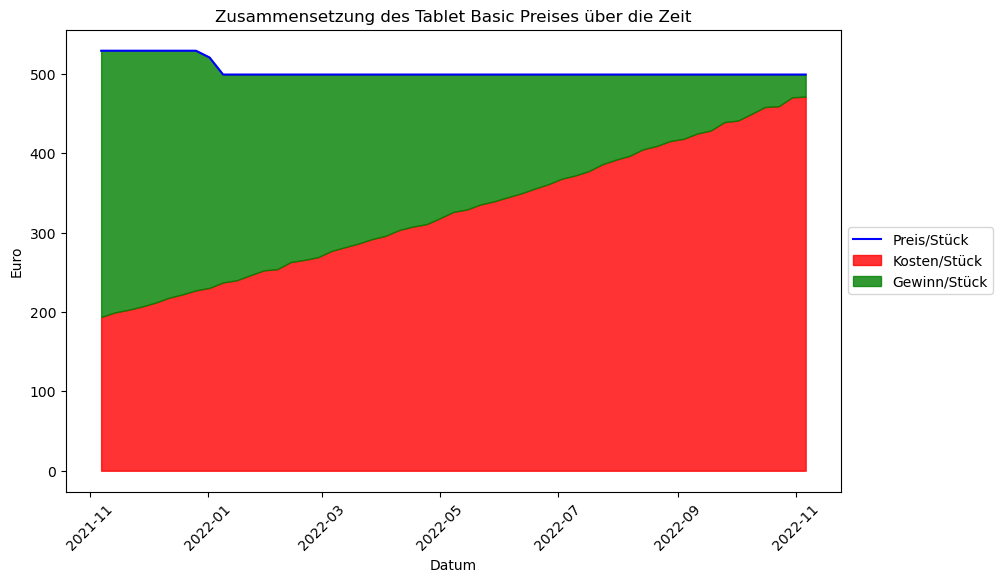

In [21]:
stats_per_week_res = stats_per_week.reset_index()

plt.figure(figsize=(10, 6))


ax = sns.lineplot(x='date', y='price', data=stats_per_week_res, label='Preis/Stück', color='blue')
plt.fill_between(stats_per_week_res['date'], 0, stats_per_week_res['cost_per_unit'], label='Kosten/Stück', color='red', alpha=0.8)
plt.fill_between(stats_per_week_res['date'], stats_per_week_res['cost_per_unit'], stats_per_week_res['cost_per_unit'] + stats_per_week_res['profit_per_unit'], label='Gewinn/Stück', color='green', alpha=0.8)



ax.set(title="Zusammensetzung des Tablet Basic Preises über die Zeit", xlabel="Datum", ylabel="Euro")
#format_lineplot2(ax)
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [24]:
def plot_zusammensetzung_preis_per_marketplace(df, marketplace):
    temp = df[df["marketplace"]==f"{marketplace}"]
    temp_group = temp.groupby(pd.Grouper(key="date",freq="1M")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "mean"})
    temp_group = temp_group.reset_index()
    #print(temp_group)

    plt.figure(figsize=(6, 3))


    ax = sns.lineplot(x='date', y='price', data=temp_group, label='Preis/Stück', color='blue')
    plt.fill_between(temp_group['date'], 0, temp_group['cost_per_unit'], label='Kosten/Stück', color='red', alpha=0.8)
    plt.fill_between(temp_group['date'], temp_group['cost_per_unit'], temp_group['cost_per_unit'] + temp_group['profit_per_unit'], label='Gewinn/Stück', color='green', alpha=0.8)



    if marketplace == "online":
        marketplace="Online"
    elif marketplace == "phone":
        marketplace="Telefon"
    elif marketplace == "store":
        marketplace="Store"
    else:
        marketplace="Unbekannter Marktplatz"


    ax.set(title=f"{marketplace} - Zusammensetzung Tablet Basic Preis", xlabel="Datum", ylabel="Euro")
    format_lineplot2(ax)
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Ist das Tablet Basic nicht profitabel?
Nachfolgend soll die These "Das Tabelt Basic ist nicht profitabel." in Bezug auf Marktplatz und region analysiert werden.

Dazu wird eine Darstellung gewählt, die pro Marktplatz Erlös / Preis und Kosten ins Verhältnis stellt. Es wird also die Entwicklung des Gewinns pro Stück betrachtet. Nachfolgend ist eine Grafik pro Marktplatz und pro Region zu sehen.

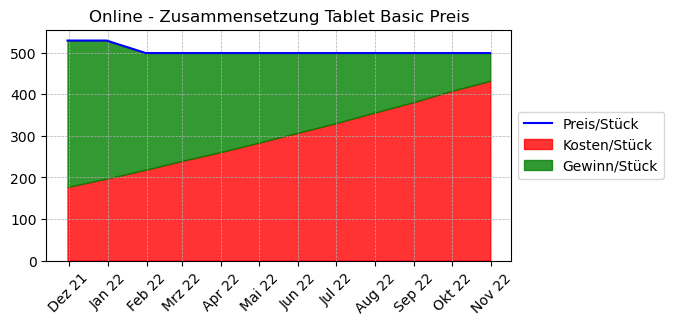

In [25]:

plot_zusammensetzung_preis_per_marketplace(df_basic, "online")

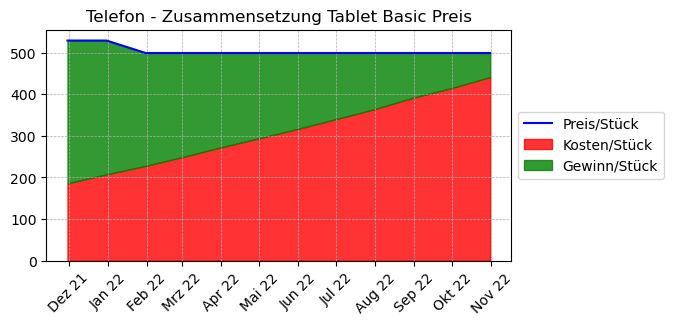

In [ ]:
plot_zusammensetzung_preis_per_marketplace(df_basic, "phone")

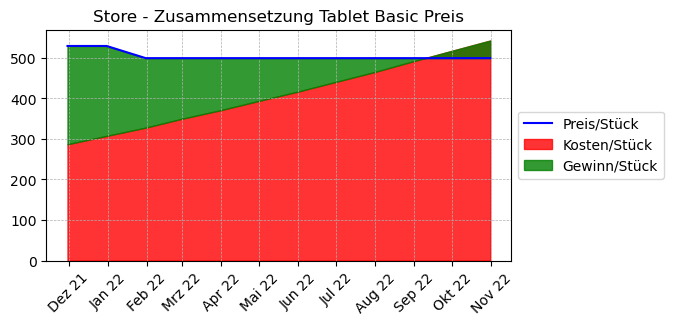

In [ ]:
plot_zusammensetzung_preis_per_marketplace(df_basic, "store")

Die Darstellungen zeigen, dass das Tablet Basic auf jedem Marktplatz zunehmend weniger Gewinn pro Stück erwirtschaftet. Im Store erwirtschaftet es seit September 2022 keinen Gewinn mehr, sondern führt zu Verlusten pro Stück.

In [26]:
def plot_zusammensetzung_preis_per_region(df, region):
    temp = df[df["region"]==f"{region}"]
    temp_group = temp.groupby(pd.Grouper(key="date",freq="1M")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "mean"})
    temp_group = temp_group.reset_index()

    plt.figure(figsize=(6, 3))


    ax = sns.lineplot(x='date', y='price', data=temp_group, label='Preis/Stück', color='blue')
    plt.fill_between(temp_group['date'], 0, temp_group['cost_per_unit'], label='Kosten/Stück', color='red', alpha=0.8)
    plt.fill_between(temp_group['date'], temp_group['cost_per_unit'], temp_group['cost_per_unit'] + temp_group['profit_per_unit'], label='Gewinn/Stück', color='green', alpha=0.8)



    ax.set(title=f"Region {region} - Zusammensetzung Tablet Basic Preis", xlabel="Datum", ylabel="Euro")
    format_lineplot2(ax)
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    return temp



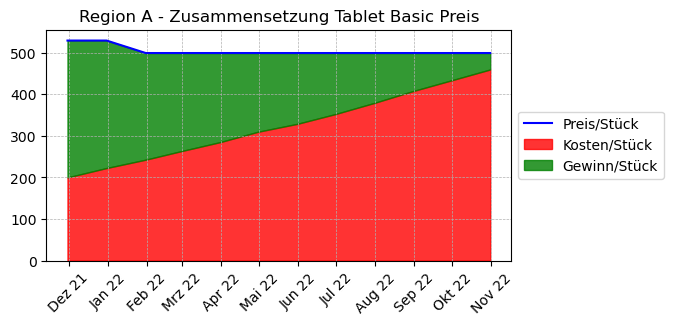

In [27]:
a = plot_zusammensetzung_preis_per_region(df_basic, "A")

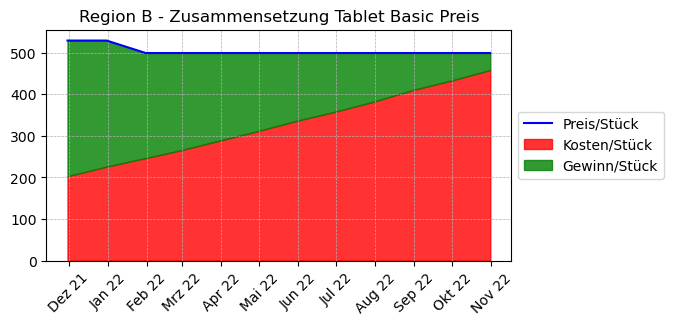

In [28]:
b = plot_zusammensetzung_preis_per_region(df_basic, "B")

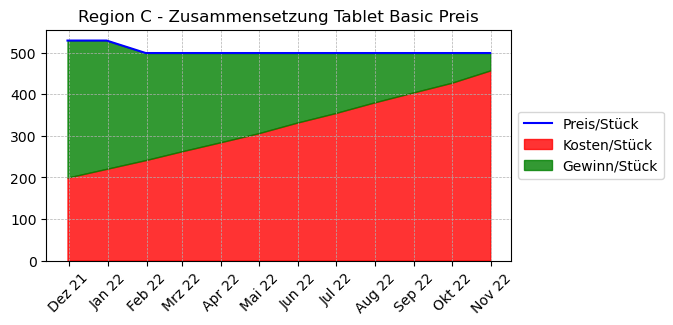

In [29]:
c = plot_zusammensetzung_preis_per_region(df_basic, "C")

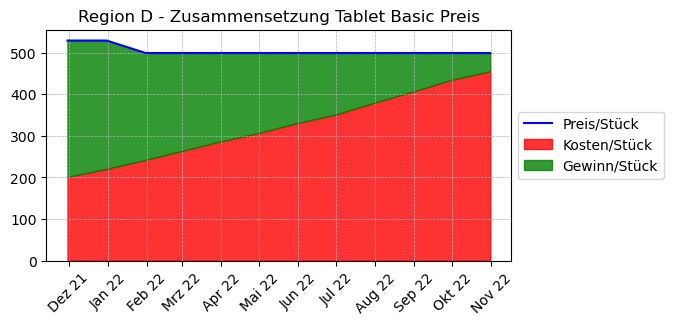

In [30]:
d = plot_zusammensetzung_preis_per_region(df_basic, "D")

Bei der Betrachtung der Entwicklung des Gewinns pro Stück in den vier verschiedenen Regionen lässt sich kein Unterschied zwischen den Regionen erkennen. Der Gewinn pro Stück entwickelt sich in allen Regionen identisch negativ. Das Tablet Basic fährt in keiner Region Verluste pro Stück ein.

# Veraltet

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


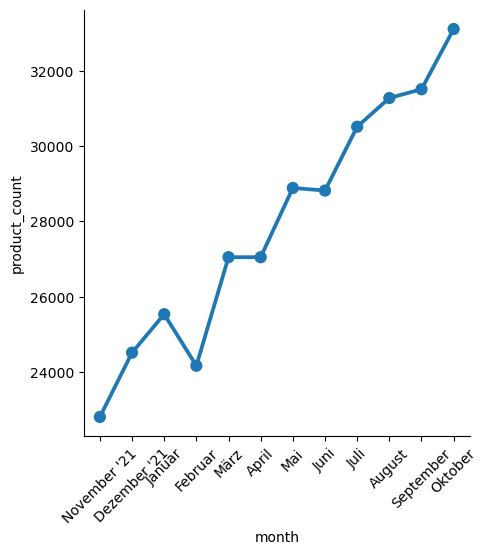

In [ ]:
# Veraltet

def aggregate_per_month(df, column_to_agg, agg_function, return_daily=False):
    '''
    Funktion, um eine Spalte des df_reg_main korrekt nach dem Monat(-sende) zu aggregieren.
    df = df_reg_main
    column_to_agg = Spalte die aggregiert werden soll
    agg_function = Funktion nach der aggregiert werden soll (wenn z.B. die Anzahl der Reihen gezählt werden soll -> "count", es geht auch "sum" oder "mean")
    '''
    
    # transaktionsdaten nach tag aggregieren (ausgehend von date spalte)
    df_count_daily = df.groupby("date").agg({column_to_agg: agg_function}) 

    # entsprechend der aggregations art die summe nehmen bei der monatlichen aggregation oder den mittelwert
    if agg_function == "count" or agg_function == "sum":
        df_monthly = df_count_daily.resample('M').sum()
    elif agg_function == "mean":
        df_monthly = df_count_daily.resample('M').mean()
    else:
        raise Error('Diese Aggregationsfunktion ist (noch) nicht in der Funktion "aggregate_per_month" vorgesehen.')

    # umbenennen der spalte sodass man weiß was da dann drin steht
    column_name = f"{column_to_agg}_{agg_function}"
    df_monthly.rename(columns={column_to_agg: column_name}, inplace=True)

    # Monat aus dem "date" extrahieren und neue Spalte erstellen
    df_monthly['month'] = df_monthly.index.month
    # Monate durch die Namen der Monate ersetzen (für die Darstellung)
    monate = ["Januar", "Februar", "März", "April", "Mai", "Juni", "Juli", "August", "September", "Oktober", "November '21", "Dezember '21"]
    df_monthly.replace([int(i) for i in np.linspace(1,12,12)], monate, inplace=True)
    # ändern der reihenfolge der spalten damit monat vorn steht
    df_monthly = df_monthly[["month", column_name]]

    if return_daily:
        return df_monthly, df_count_daily

    return df_monthly

# Monatliche Aggregation
monthly_transactions = aggregate_per_month(df_reg_main, "product", "count")

cat = sns.catplot(data=monthly_transactions, x="month", y="product_count", kind="point", errorbar=None)
cat.set_xticklabels(rotation=45)